DATA SCIENCE AND ANALYTICS IN A "PANDEMIC"

- Original Script Generated by: Andrew Atkenson, Thomas J. Sargent & John Stachurski
- Script Modified by: Abdullah Zahid
- The purpose of this notebook is quantitative modeling of COVID-19 using a standard SIR (Susceptible-Infected-Removed) model of the spread. The objective is to study the impact of suppression throuhg social distancing on the spread of infections. 

- This script entails the data structure visualization referenced as Figure 9 in the publication.

We will use the following standard imports:

In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,5) #set default figure size
import numpy as np
from numpy import exp
from scipy.integrate import odeint 

In the version of the SIR model we will analyze there are four states.

All individuals in the population are assumed to be in one of these four states.

The states are: susceptible (S), exposed (E), infected (I) and removed (R).


Those in state R have been infected and either recovered or died.

Those who have recovered are assumed to have acquired immunity.

Those in the exposed group are not yet infectious.



In [153]:
pop_size = 3.3e8 #this can be changed for different countries, for now set for US


In [154]:
γ=1/18 #average illness duration of 18 days
σ = 1/5.2 #average incubation period of 5.2 days

In [155]:
def F(x, t, R0=2.66): #transmission rate taken from https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0244474 
    """
    Time derivative of the state vector.

        * x is the state vector (array_like)
        * t is time (scalar)
        * R0 is the effective transmission rate, defaulting to a constant

    """
    s, e, i = x

    # New exposure of susceptibles
    β = R0(t) * γ if callable(R0) else R0 * γ
    ne = β * s * i

    # Time derivatives
    ds = - ne
    de = ne - σ * e
    di = σ * e - γ * i

    return ds, de, di

In [156]:
i_0 = 1e-7
e_0 = 4* i_0
s_0 = 1 - i_0 - e_0

x_0 = s_0, e_0, i_0

In [157]:
def solve_path(R0, t_vec, x_init=x_0):
    """
    Solve for i(t) and c(t) via numerical integration,
    given the time path for R0.

    """
    G = lambda x, t: F(x, t, R0)
    s_path, e_path, i_path = odeint(G, x_init, t_vec).transpose()

    c_path = 1 - s_path - e_path #represents cumulative cases
    return i_path, c_path

For experiment, the period of investigation would be 365 days or a whole year

In [158]:
t_length = 365
grid_size = 1000
t_vec = np.linspace(0, t_length, grid_size)

##Experiment 1: Constant R0 Case
We will begin with the case that our effective transmission rate is constant. We calculate the time path of infected people under different assumptions for R0:

In [159]:
R0_vals = np.linspace(2.66, 3.5, 6) 
labels = [f'$R0 = {r:.2f}$' for r in R0_vals]
i_paths, c_paths = [], []

for r in R0_vals:
    i_path, c_path = solve_path(r, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)
    

In [160]:
def plot_paths(paths, labels, times=t_vec):
    fig, ax = plt.subplots()
    for path, label in zip(paths, labels):
        ax.plot(times, path, label=label)
        
    ax.legend(loc='upper left')
    plt.show()

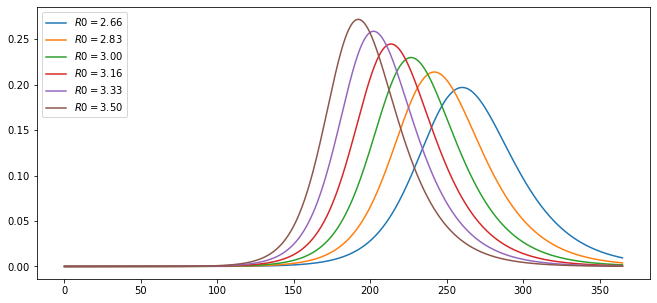

In [161]:
plot_paths(i_paths, labels)

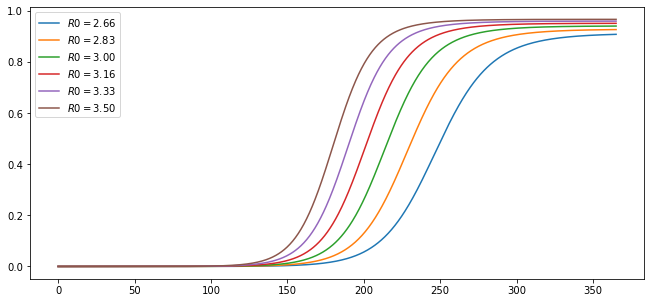

In [162]:
plot_paths(c_paths, labels)

As seen abover lower effective transmission rates defer the peak of infections and also lead to a lower peak in current cases as we can see the plot of cumuative cases as fraction of population.

Let’s look at a scenario where mitigation (social distancing, vaccination etc.) is successively imposed.

Here’s a specification for R0 as a function of time:

In [190]:
def R0_mitigating(t, r0=2.66, η=1, r_bar=0.92):
    R0 = r0 * exp(- η * t) + (1 - exp(- η * t)) * r_bar
    return R0

The idea that R0 starts off at January rate of 2.66 and falls to the current rate of 0.92. This is due to the progressive adoption of stric mitigating measures. The parameter. The parameter η controls the rate, or the speed at which restrictions are imposed.

We consider several different rates:

In [191]:
η_vals = 1/5, 1/10, 1/20, 1/50, 1/100
labels = [fr'$\eta = {η:.2f}$' for η in η_vals]

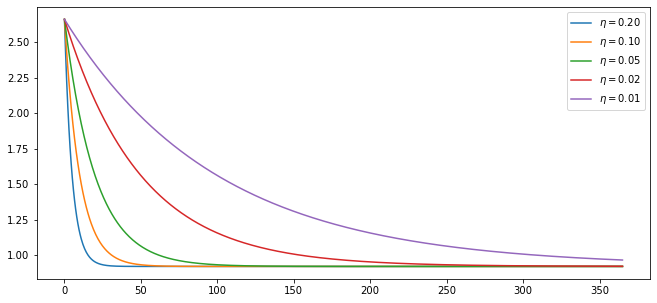

In [192]:
fig, ax = plt.subplots()

for η, label in zip(η_vals, labels):
    ax.plot(t_vec, R0_mitigating(t_vec, η=η), label=label)

ax.legend()
plt.show()

As we can see from the plot above, the effective transmission rate would reduce to the current present date much quicker if the rate at which mitigating response are imposed more quickly or at higher rate.

In [193]:
i_paths, c_paths = [], []

for η in η_vals:
    R0 = lambda t: R0_mitigating(t, η=η)
    i_path, c_path = solve_path(R0, t_vec)
    i_paths.append(i_path)
    c_paths.append(c_path)

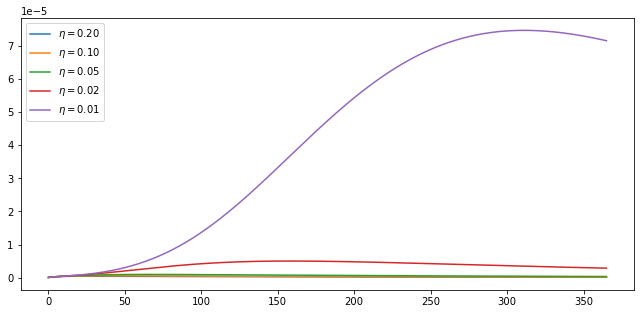

In [194]:
plot_paths(i_paths, labels)

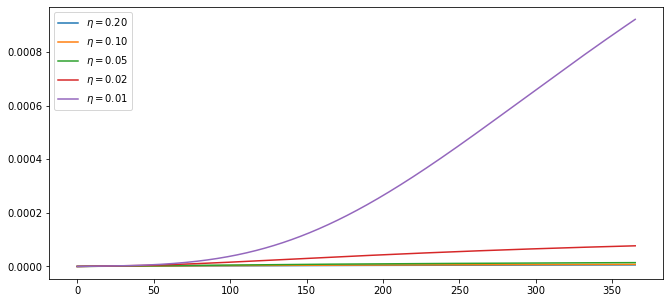

In [195]:
plot_paths(c_paths, labels)

The time path of infected people also is seen to be only high and constantly growing for slow speed of restrictions imposed as we see exponential increase after the 150th day mark with peak only around 300th day. Same for the cumulative cases plot that indicate a continous rise in cumulative cases at slow speed of restrictions imposition. 

Consider these two mitigation scenarios:

Rt = 0.5 for 30 days and then Rt = 2  for the remaining 17 months. This corresponds to lifting lockdown in 30 days.

Rt = 0.5 for 120 days and then Rt = 2  for the remaining 14 months. This corresponds to lifting lockdown in 4 months.

Our intitial conditions take into account COVID data taken from https://covidtracking.com/data/download which indicated mid-January infected of 164,128 whilst exposure of 200,000.

In [189]:
#initial conditions
i_0 = 164_128 / pop_size
e_0 = 200_000 / pop_size
s_0 = 1 - i_0 - e_0
x_0 = s_0, e_0, i_0


In [196]:
R0_paths = (lambda t: 0.5 if t < 30 else 2,
            lambda t: 0.5 if t < 120 else 2)

labels = [f'scenario {i}' for i in (1, 2)]

i_paths, c_paths = [], []

for R0 in R0_paths:
    i_path, c_path = solve_path(R0, t_vec, x_init=x_0)
    i_paths.append(i_path)
    c_paths.append(c_path)

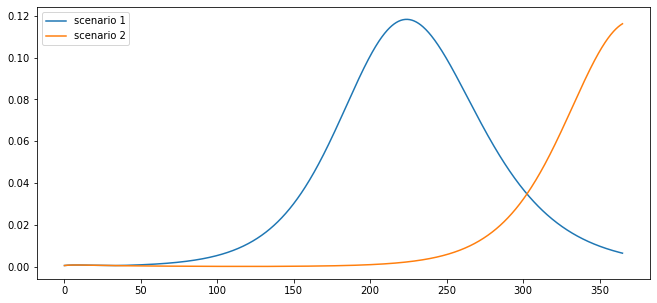

In [197]:
plot_paths(i_paths, labels)

We see that in this case scenario two is much more beneificial in comparison to scenario 1 as the  strict lockdown for 4 months means that the peak can be pushed further to a whole year that would be enough time for a vaccine roll out or administeration. Whilst a 30 day lockdown means that the peak of infected cases would arive by the 215th day.

Considering a COVID mortality rate of 1% we wanted to investigate mortality comparison for these scenarios.

In [198]:
v = 0.01

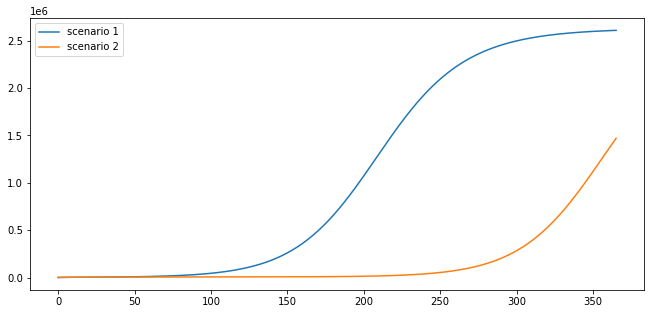

In [199]:
paths = [path * v * pop_size for path in c_paths]
plot_paths(paths, labels)

The plot above represents the cumulative number of deaths for 30 day lockdown which seems to increase dramatically at the 200th day mark and shows signs of levelling off beyond the year mark whilst for scenario 2 the cumulative deaths are pushed further into the year with no peak seen within 365 day mark.

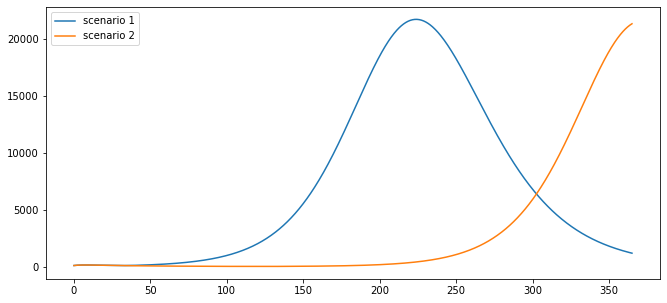

In [200]:
paths = [path * v *γ * pop_size for path in i_paths]
plot_paths(paths, labels) 

The plot above shows the daily death rate which for 30 day lockdown seems to peak much more earlier as compared to a 4 month lockdown that shows the peak to be delayed beyond the year.